In [139]:
import numpy as np
import cv2 as cv
import os
from matplotlib import pyplot as plt
from matplotlib.patches import ConnectionPatch
%matplotlib inline

In [140]:
def load_img(img_path, resize=True):
    raw = cv.imread(img_path, 0)
    if resize:
        height, width = raw.shape
        if height >= 400 and height <= 600:
            return raw
        elif height > 600:
            scale = round(height/500.0, 2)
            res_w = int(round(width/scale))
            # resize(src, (new_width, new_height)
            return cv.resize(raw, (res_w, 500))
        else:
            raise ValueError("Input shape (%d, %d) is too small.", rows, cols)


def get_first_keyframe():
    """
    Write something on screen -- tell user to hit <space> to capture.
    """
    # Sample `right` image for now ...
    return load_img('./samples/left.jpg')


def get_second_keyfame():
    """
    Write something on screen -- tell user to hit <space> to capture.
    """
    # Sample 'left' image for now ...
    return load_img('./samples/right.jpg')

In [141]:
def eight_pt(pts_before, pts_after, hnorm, wnorm):
    assert pts_before.shape == pts_after.shape
    size = pts_before.shape[0]
    assert size >= 8

    A = np.zeros((9 * size, 9))

    for ix in range(size):
        y1, y2 = pts_before[ix]  # Before (y)
        y1, y2 = hnorm(y1), wnorm(y2)

        yp1, yp2 = pts_after[ix]  # After (y')
        yp1, yp2 = hnorm(yp1), wnorm(yp2)

        row = [yp1 * y1, yp1 * y2, yp1,
               yp2 * y1, yp2 * y2, yp2,
               y1, y2, 1]

        A[ix] = row

    u, s, vh = np.linalg.svd(A)
    Eest = vh[np.argmin(s)].reshape(3, 3)

    # Enforce the singular value consistency in the Essential Matrix.
    u, s, vh = np.linalg.svd(Eest)
    s.sort()
    sprime = np.zeros((3, 3))
    sprime[0, 0] = s[-1]
    sprime[1, 1] = s[-2]

    return u.dot(sprime).dot(vh)

In [142]:
def prepare_matches(kps_first, kps_second, matches):
    points_first, points_second = [], []
    for m in matches:
        if m.imgIdx == 0:
            train, query = kps_first[m.queryIdx].pt, kps_second[m.trainIdx].pt
        elif m.imgIdx == 1:
            query, train = kps_first[m.queryIdx].pt, kps_second[m.trainIdx].pt
        else:
            raise ValueError("Unknown imgIdx in DMatch object.")

        points_first.append(train)
        points_second.append(query)

    return np.array(points_first), np.array(points_second)

In [143]:
def znm(mu, sigma):
    def normalize(x, m=mu, s=sigma):
        return (x - m)/(1.0 * s)
    return normalize

In [144]:
kf_first = get_first_keyframe()
kf_second = get_second_keyfame()

print kf_first.shape, kf_second.shape
assert kf_first.shape == kf_second.shape, "1st, 2nd keyframes shapes mismatch"

(459, 612) (459, 612)


In [145]:
height, width = kf_first.shape
hmu, hsig = np.mean(np.arange(height)), np.std(np.arange(height))
wmu, wsig = np.mean(np.arange(width)), np.std(np.arange(width))

In [146]:
hnorm = znm(hmu, hsig)
wnorm = znm(wmu, wsig)

In [147]:
orb = cv.ORB_create()
bfm = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

kps_first, des_first = orb.detectAndCompute(kf_first, None)
kps_second, des_second = orb.detectAndCompute(kf_second, None)

matches = bfm.match(des_first, des_second)
assert all(_.imgIdx==0 for _ in matches) == True
total = len(matches)
top50 = int(0.5 * total)
top_matches = sorted(matches, key=lambda x:x.distance)[:top50]

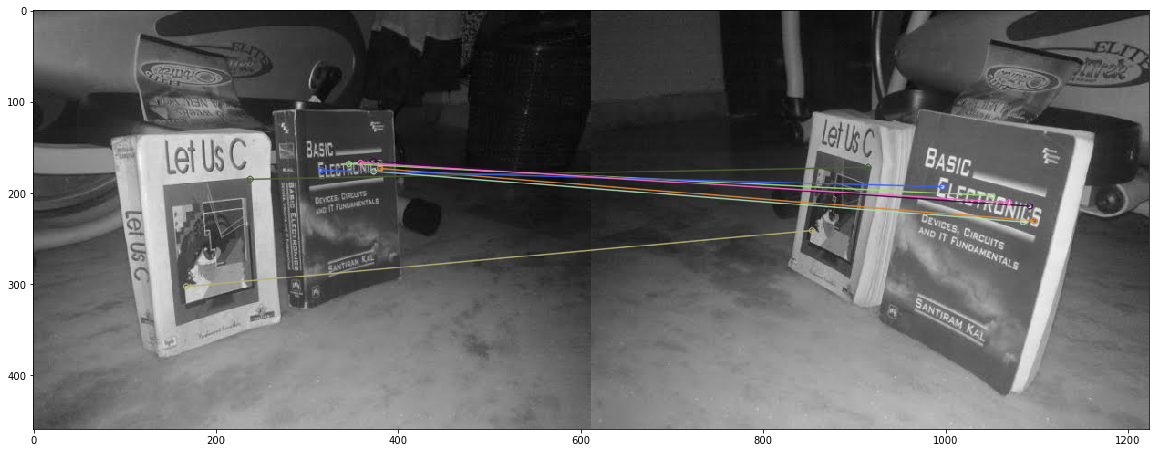

In [148]:
# Just plotting ...
_img = cv.drawMatches(kf_first, kps_first, kf_second, kps_second, top_matches[:8],
                      None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(20, 25))
plt.imshow(_img);

In [159]:
pts_first, pts_second = prepare_matches(kps_first, kps_second, top_matches)
for row in zip(pts_first, pts_second):
    print row

(array([380., 173.]), array([485.2800293 , 230.40000916]))
(array([346., 168.]), array([439.20001221, 203.04000854]))
(array([237.6000061 , 184.80000305]), array([303.57510376, 171.69412231]))
(array([167.61601257, 302.40002441]), array([242., 241.]))
(array([373., 165.]), array([480.96002197, 214.56001282]))
(array([373.20001221, 176.40000916]), array([473.4720459 , 231.55201721]))
(array([316., 175.]), array([385.20001221, 193.20001221]))
(array([359., 167.]), array([457.92001343, 210.24000549]))
(array([372., 177.]), array([472.32000732, 230.40000916]))
(array([231.55201721, 300.67202759]), array([482.73419189, 246.34373474]))
(array([301.20001221, 151.20001221]), array([371.52005005, 157.24801636]))
(array([168.48001099, 318.24002075]), array([240., 252.]))
(array([378., 170.]), array([485.2800293 , 224.64001465]))
(array([194., 176.]), array([253.80870056, 176.67076111]))
(array([238., 184.]), array([304.12802124, 172.80001831]))
(array([315.36001587, 182.88000488]), array([380.16

In [160]:
Emat = eight_pt(pts_before=pts_first, pts_after=pts_second, hnorm=lambda x:x, wnorm=lambda x:x)
CVEmat, mask = cv.findFundamentalMat(np.int32(pts_first), np.int32(pts_second), cv.FM_RANSAC)

In [161]:
Emat

array([[-2.32637505e-06, -2.81728045e-06,  1.09330943e-03],
       [-5.12093848e-06, -7.92152748e-06,  2.85602662e-03],
       [ 1.99221295e-03,  2.65650734e-03, -9.99989811e-01]])

In [162]:
CVEmat

array([[ 5.89748977e-06,  2.35568140e-05, -5.05315558e-03],
       [-1.84907917e-05,  4.42756846e-06,  3.42226522e-03],
       [ 9.29922226e-04, -7.61007742e-03,  1.00000000e+00]])

### Select inlier points ...

In [163]:
pts_first = pts_first[mask.ravel() == 1]
pts_second = pts_second[mask.ravel() == 1]

### Manually compute Epilines ...

In [164]:
CVlines = cv.computeCorrespondEpilines(pts_first.reshape(-1,1,2), 1, CVEmat)
CVlines[0].flatten()

array([ 0.40661355, -0.91360025, 11.85413925])

In [132]:
def get_points_for_line(img, line):
    r, c = img.shape
    r = line
    x0,y0 = map(int, [0, -r[2]/r[1] ])
    x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
    return (x0, y0), (x1, y1)

In [165]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv.cvtColor(img1,cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2,cv.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

In [166]:
img_a, img_b = drawlines(img1=kf_second, img2=kf_first, lines=CVlines.reshape(-1, 3), 
                         pts1=pts_second.astype(np.int32), pts2=pts_first.astype(np.int32))

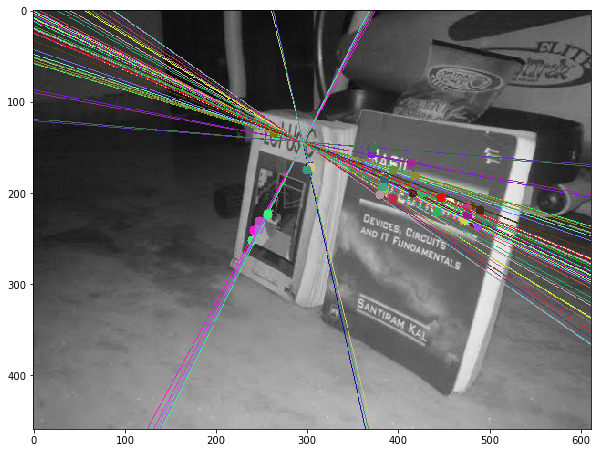

In [167]:
plt.figure(figsize=(10, 15))
plt.imshow(img_a)